In [1]:
from begepro.autoencoder.sn_analysis import Comparison, compute_threshold
from begepro.autoencoder.dataloading import DataLoader, Dataset
from begepro.autoencoder.autoencoder_classifier import Autoencoder, Classifier

import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

2023-02-09 23:00:21.960662: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-09 23:00:22.058500: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-09 23:00:22.058515: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-09 23:00:22.535688: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
opts = {"loadpath": "/mnt/e/BEGE_data/waveforms_crioconite", # where .bin files are stored
"savepath": "../../dataset/crioconite", # where .npy files will be saved with readfiles() and loaded with load()
"subsampling_factor": 3}
dataloader = DataLoader(opts)

waveforms, currents, energies, amplitudes, pulse_height = dataloader.load()

autoencoder_class = Autoencoder()
classifier_class = Classifier(input_size = 5)
autoencoder_class.load_model("../../models/autoencoder", "../../models/encoder")
classifier_class.load_model("../../models/classifier")

2023-02-09 23:00:23.754887: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-02-09 23:00:23.754935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DARTWARS0): /proc/driver/nvidia/version does not exist
2023-02-09 23:00:23.755144: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
mus = np.array([4.778311 , 4.25894  , 3.7369454, 4.971836 , 3.8563824])
stds = np.array([1.23048101e-03, 6.46553329e-04, 6.02247721e-01, 6.72660279e-01,
        4.74731220e-05])

In [4]:
predictions, _, _ = autoencoder_class.encode(waveforms, mus, stds)

   59/46875 [..............................] - ETA: 40s    

2023-02-09 23:00:24.765997: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 732000000 exceeds 10% of free system memory.


46875/46875 [==============================] - 35s 751us/step


In [5]:
scores = classifier_class.classifier.predict(predictions)[:,0]

46875/46875 [==============================] - 33s 708us/step


In [6]:
avse = amplitudes/pulse_height

0.018284367639618788


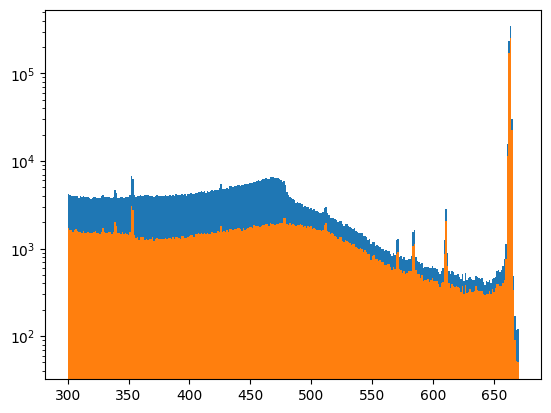

In [7]:
predictions_nn = scores > 0.3
avse_threshold = compute_threshold(avse, predictions_nn.sum(), "avse", stress_limit = 100000)
print(avse_threshold)
nbins = 301
plt.hist(energies, range = [300, 670], bins = nbins)[-1]
plt.hist(energies[predictions_nn], range = [300, 670], bins = nbins)[-1]

plt.yscale("log")

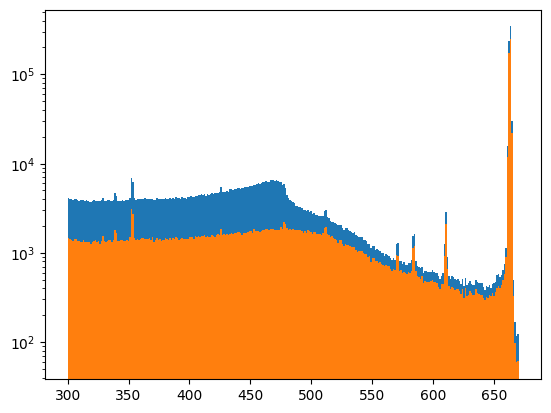

In [8]:
plt.hist(energies, range = [300, 670], bins = nbins)[-1]
plt.hist(energies[avse < avse_threshold], range = [300, 670], bins = nbins)[-1]
plt.yscale("log")

In [15]:
comparison = Comparison(energies, avse, scores)
M_ELECTRON = 511
cs = np.linspace(0.0, 0.69, 100)
peaks = [478]
sb_nn, std_sb_nn, sb_avse, std_sb_avse = comparison.compare([478], cs, benchmark = "nn", width = 10, nbins = 19)

Estimating S/B for peak at 478 keV


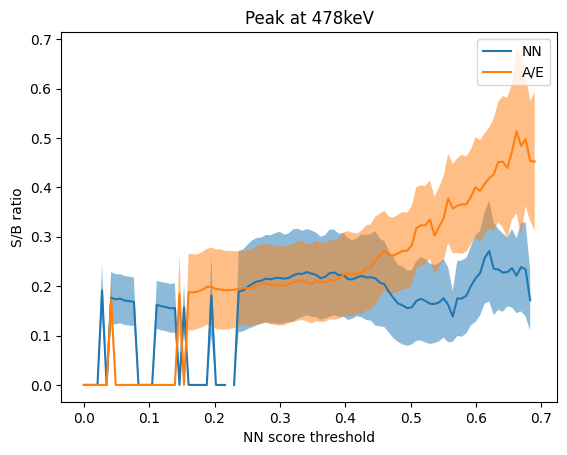

In [16]:
for n in range(len(peaks)):
    plt.plot(cs, sb_nn[:,n])
    plt.fill_between(cs, sb_nn[:,n] + std_sb_nn[:,n], sb_nn[:,n] - std_sb_nn[:,n],label='_nolegend_', alpha = 0.5)
    plt.plot(cs, sb_avse[:,n])
    plt.fill_between(cs, sb_avse[:,n] + std_sb_avse[:,n], sb_avse[:,n] - std_sb_avse[:,n],label='_nolegend_', alpha = 0.5)
    plt.xlabel("NN score threshold")
    plt.ylabel("S/B ratio")
    plt.title(f"Peak at {peaks[n]}keV")
    plt.legend(["NN", "A/E"])
    plt.savefig(f"../../results/z_peak_at_{peaks[n]}_122_sampling.svg")
    # plt.clf()